# Application of `moscot.spatiotemporal` to MOSTA w/ `CellRank` over brain cells


Uses `moscot.spatiotemporal` mappings between brain cells to create a CellRank kernel. 


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

In [3]:
from datetime import datetime
import glob
import numpy as np
from copy import copy
import pickle
from matplotlib.colors import ListedColormap

import scanpy as sc
import anndata
import squidpy as sq
import cellrank as cr
import pandas as pd


import seaborn as sns
from matplotlib import colors as mcolors, pyplot as plt
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
from cellrank.estimators import GPCCA

from typing import *
from types import MappingProxyType

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
cr.logging.print_version_and_date()

Running CellRank 1.5.1+g5853d0e0, on 2023-05-01 23:45.


## Dependencies

Requires following steps in `3_Brain_analysis/0_Brain_mapping` to create:
1. `mouse_embryo_brain_labels.h5ad`
2. `mouse_embryo_brain_tmats.pkl`
3. `colors_dict.pickle`
4. `groups_dict.pickle`


Files:
1. `Mus_musculus_TF.txt`: downloaded from [AnimalTFDB3.0](http://bioinfo.life.hust.edu.cn/static/AnimalTFDB3/download/Mus_musculus_TF)

## Define utility functions

Define a custom kernel class to convert moslin's couplings into a CellRank kernel.

In [6]:
class MostaKernel(cr.kernels.TransportMapKernel):
    
    def compute_transition_matrix(
        self,
        tmaps: Dict[Tuple[float, float], anndata.AnnData],
        threshold: Optional[str] = "auto",
        self_transitions: Union[
            Literal["uniform", "diagonal", "connectivities", "all"],
            Sequence[float],
        ] = "connectivities",
        conn_weight: Optional[float] = None,
        conn_kwargs: Mapping[str, Any] = MappingProxyType({}),
    ):
        self._tmaps = tmaps

        if threshold is not None:
            self._threshold_transport_maps(
                self.transport_maps, threshold=threshold, copy=False
            )

        tmap = self._restich_tmaps(
            self.transport_maps,
            self_transitions=self_transitions,
            conn_weight=conn_weight,
            **conn_kwargs,
        )

        self.transition_matrix = tmap.X
        return self

    def _compute_tmap(self):
        raise NotImplementedError()

Return a sorted df of driver genes, subsetted to the relevant columns.

In [7]:
def return_drivers(adata, states, q_thresh = None, n_genes = 20, gene_list = None, TF = False):
    state = states[0]
    cols = ['highly_variable', 'highly_variable_rank']
    for state in states:
        cols.append(f"{state}_pval")
        cols.append(f"{state}_corr")
    if q_thresh is not None:
        mask = adata.var[f"{state}_qval"] < q_thresh
    elif gene_list is not None:
        mask = adata.var_names.isin(gene_list)
    elif TF:
        mask = adata.var["TF"]
    else: 
        mask = np.ones(adata.n_vars).astype(bool)
    
    if gene_list is not None:
        gene_df = adata[:, mask].var.sort_values(by=f"{state}_corr", ascending=False)[cols]
    else:
        gene_df = adata[:, mask].var.sort_values(by=f"{state}_corr", ascending=False).head(n_genes)[cols]          
    return gene_df

## Set up paths

In [8]:
sys.path.insert(0, "../../")  # this depends on the notebook depth and must be adapted per notebook

from paths import DATA_DIR, FIG_DIR

FIG_DIR = FIG_DIR / "space/spatiotemporal"
DATA_DIR = DATA_DIR / "space/spatiotemporal"

## Set global parameters

In [9]:
import mplscience
mplscience.set_style()
plt.rcParams["legend.scatterpoints"] = 1

In [10]:
DPI_SAVE = 400

In [11]:
save_figure = True

## Cellrank analysis

In [12]:
adata_labels = sc.read(DATA_DIR + "mouse_embryo_brain_labels.h5ad")

In [13]:
with open(DATA_DIR + "mouse_embryo_brain_tmats.pkl", "rb") as handle:
    tmats = pickle.load(handle)

In [14]:
with open(DATA_DIR + "colors_dict.pickle", "rb") as handle:
    colors_dict = pickle.load(handle)

In [15]:
with open(DATA_DIR + "group_dict.pickle", "rb") as handle:
    group_dict = pickle.load(handle)

In [16]:
t_min = 12.5

In [17]:
adata_late = adata_labels[adata_labels.obs["time"] > t_min].copy()

In [18]:
tmats_late = {key: tmat for key, tmat in tmats.items() if key[0] > t_min}

In [19]:
tfs = pd.read_csv(DATA_DIR + "Mus_musculus_TF.txt", delimiter="\t")
adata_late.var["TF"] = adata_late.var_names.isin(tfs["Symbol"])

### Create kernel

In [20]:
del adata_late.obsm["X_pca"]
del adata_late.obsm["X_umap"]

In [21]:
adata_late.X = adata_late.layers["counts"].copy()

sc.pp.highly_variable_genes(adata_late, flavor="seurat_v3", n_top_genes=2000, subset=False, batch_key="time")
sc.pp.normalize_total(adata_late)
sc.pp.log1p(adata_late)
sc.pp.pca(adata_late, use_highly_variable=True)
sc.pp.neighbors(adata_late)
sc.tl.umap(adata_late)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [22]:
adata_late.obs["time"] = adata_late.obs["time"].astype("category")

In [23]:
adata_late.uns["spatial"] = {"library_id": []}
adata_late.uns["spatial_dicts"] = {}

In [24]:
adata_late.uns["spatial_dicts"]["time_size"] = {
    13.5:.5,
    14.5:.5,
    15.5:.5,
    16.5:15,
} 

In [25]:
adata_late.uns["spatial_dicts"]["ylim"] = {}
for time in adata_late.obs["time"].cat.categories:
    min_ = np.min(adata_late[adata_late.obs["time"].isin([time])].obsm["spatial"][:, 1])
    max_ = np.max(adata_late[adata_late.obs["time"].isin([time])].obsm["spatial"][:, 1])
    perc_ = np.percentile(adata_late[adata_late.obs["time"].isin([time])].obsm["spatial"][:, 1], 99.5)
    print(f"{time}\n y 90% {perc_}, min {min_} - max {max_}")
    
    adata_late.uns["spatial_dicts"]["ylim"][time] = (perc_, min_)

13.5
 y 90% -253.2582805955732, min -374.89071482844776 - max -5.985023648715924
14.5
 y 90% -311.457639040639, min -447.57727204546205 - max -77.6918972309731
15.5
 y 90% -328.64582778825667, min -460.6402477042572 - max -14.63177902825305
16.5
 y 90% -1677.0, min -11019.0 - max -1109.0


In [26]:
adata_late.uns["spatial_dicts"]["ylim"][time] = (min_, max_)

In [27]:
min_x_155 = (adata_late[adata_late.obs["time"].isin([15.5])].obsm["spatial"][:, 0].min())
max_x_155 = (adata_late[adata_late.obs["time"].isin([15.5])].obsm["spatial"][:, 0].max())

min_y_155 = (adata_late[adata_late.obs["time"].isin([15.5])].obsm["spatial"][:, 1].min())
max_y_155 = (adata_late[adata_late.obs["time"].isin([15.5])].obsm["spatial"][:, 1].max())

diff = (min_x_155 - adata_late[adata_late.obs["time"].isin([14.5])].obsm["spatial"][:, 0].max())
width = (max_x_155 - min_x_155)*1.1
height = (max_y_155 - min_y_155)*0.5

In [28]:
min_x = (adata_late[adata_late.obs["time"].isin([16.5])].obsm["spatial"][:, 0].min())
min_y = (adata_late[adata_late.obs["time"].isin([16.5])].obsm["spatial"][:, 1].min()) + height

max_x = (adata_late[adata_late.obs["time"].isin([16.5])].obsm["spatial"][:, 0].max())
max_y = (adata_late[adata_late.obs["time"].isin([16.5])].obsm["spatial"][:, 1].max())

In [29]:
adata_late.obsm["spatial_joint"] = adata_late.obsm["spatial"].copy()
adata_late.uns["spatial_joint"] = adata_late.uns["spatial"].copy() 

In [30]:
adata_late.obsm["spatial_joint"][adata_late.obs["time"].isin([16.5]), 0] = width*(adata_late.obsm["spatial"][adata_late.obs["time"].isin([16.5]), 0] - max_x) / (max_x-min_x) + (diff*5 + max_x_155)
adata_late.obsm["spatial_joint"][adata_late.obs["time"].isin([16.5]), 1] = height*(adata_late.obsm["spatial"][adata_late.obs["time"].isin([16.5]), 1] - min_y) / (min_y-max_y) + 18*max_y_155 


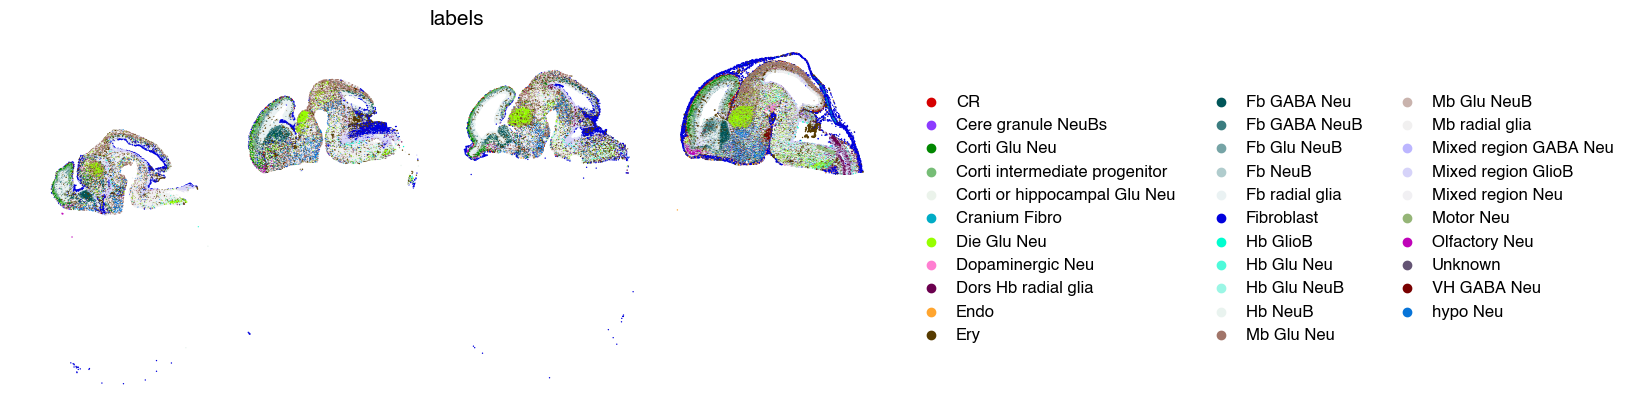

In [31]:
sq.pl.spatial_scatter(
    adata_late,
    color=["labels"], 
    size=1.,#adata_late.uns["spatial_dicts"]["time_size"][time],
    spatial_key="spatial_joint",
    img=False,
    frameon=False,
    figsize=(18,4),
)

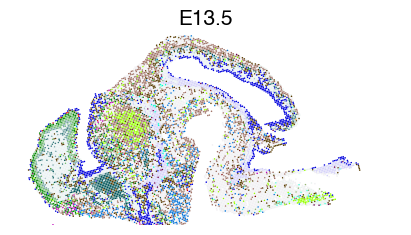

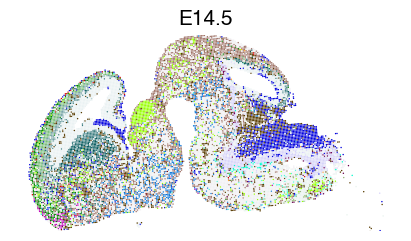

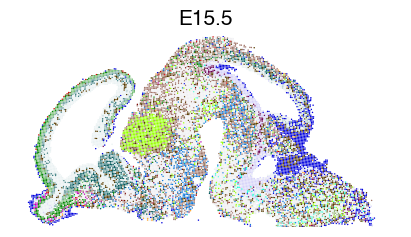

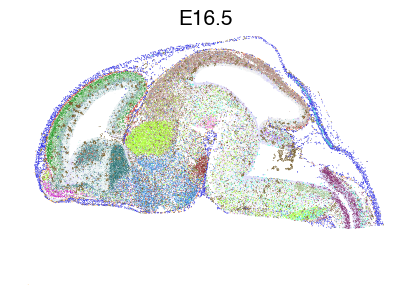

In [32]:
for time in adata_late.obs["time"].cat.categories:
    sq.pl.spatial_scatter(
        adata_late[adata_late.obs["time"].isin([time])],
        color=["labels"], 
        size=adata_late.uns["spatial_dicts"]["time_size"][time],
        img=False,
        frameon=False,
        figsize=(4,4),
    )
    plt.title(f"E{time}")
    plt.ylim(adata_late.uns["spatial_dicts"]["ylim"][time])
    plt.legend().remove()
    if save_figure:
        plt.savefig(FIG_DIR + f"E{time}_brain.png", bbox_inches="tight", transparent=True, dpi=300)
   

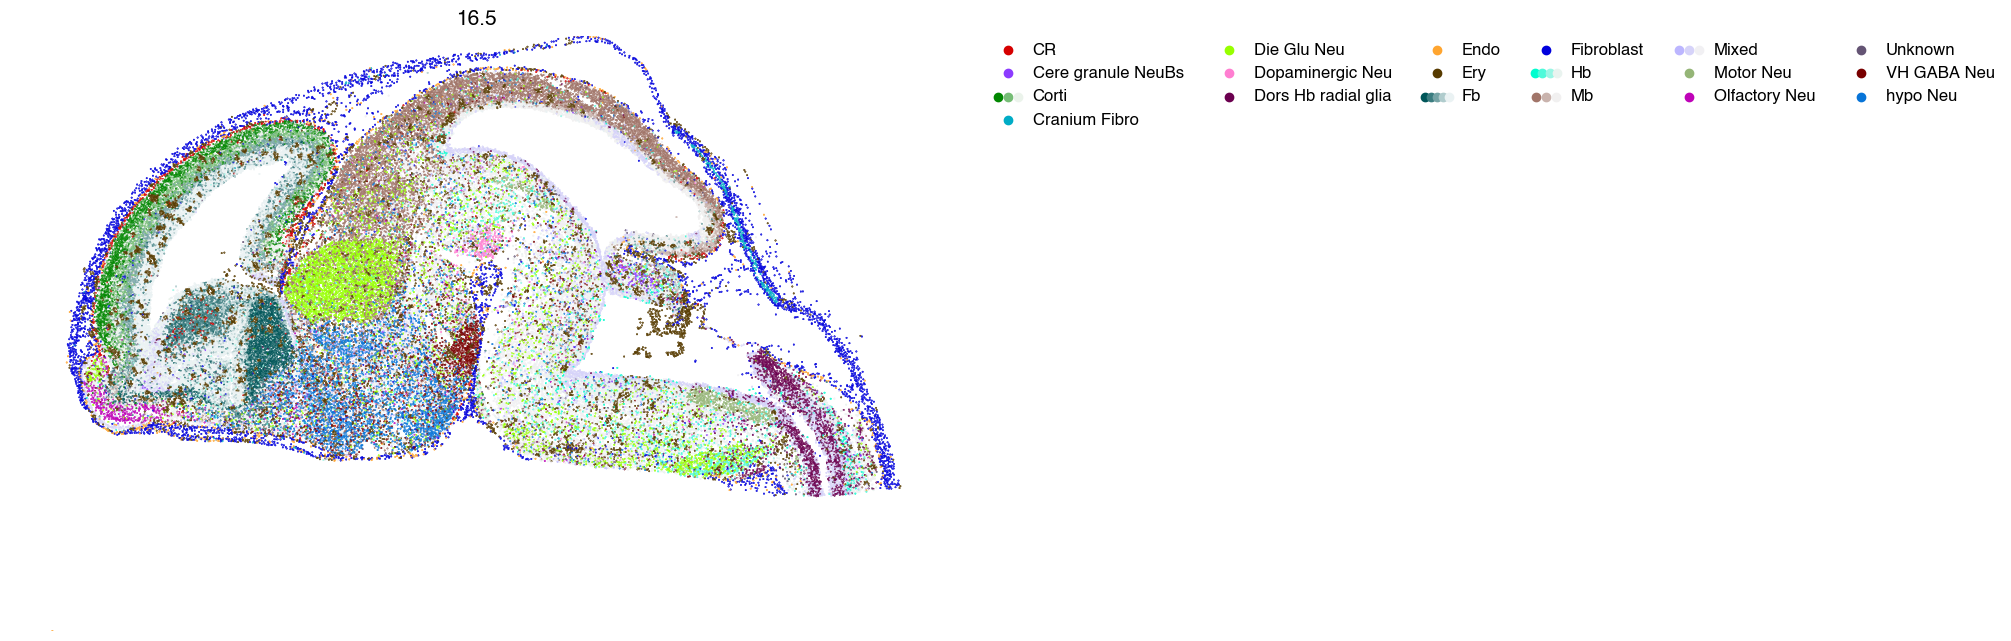

In [33]:
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
markersize = 50
ad = sq.pl.spatial_scatter(
    adata_late[adata_late.obs["time"].isin([time])],
    spatial_key="spatial",
    color="labels",
    shape=None,
    size=0.4,
    frameon=False,
    figsize=(20, 10),
    title=str(16.5),
    return_ax=True
)


h,l = ad.get_legend_handles_labels()
ls = [key_ if len(cats_) > 1 else cats_[0] for key_, cats_ in group_dict.items()]
hs = [tuple(np.asarray(h)[pd.Series(l).index[pd.Series(l).isin(cats_)].tolist()]) for key_, cats_ in group_dict.items()]
ad.legend(
    hs,
    ls,
    bbox_to_anchor=(1.05, 1), 
    loc=2, 
    borderaxespad=0., 
    ncol=6,
    handler_map={tuple: HandlerTuple(ndivide=None)})
ad.set_ylim(adata_late.uns["spatial_dicts"]["ylim"][time])

if save_figure:
    plt.savefig(FIG_DIR + f"E165_brain_legend.png", bbox_inches="tight", transparent=True, dpi=300)
plt.show()


In [34]:
mk = MostaKernel(adata_late, time_key="time").compute_transition_matrix(
    tmats_late, self_transitions="connectivities"
)
conn = cr.kernels.ConnectivityKernel(adata_late).compute_transition_matrix()

In [35]:
kernel = 0.9 * mk + 0.1 * conn

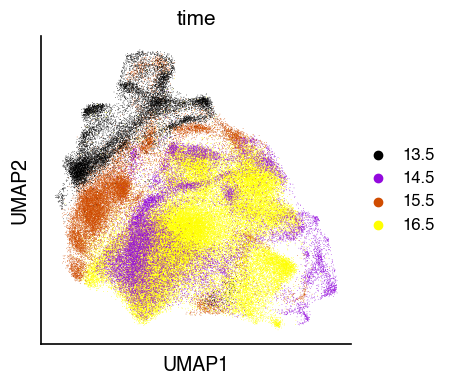

In [36]:
sc.pl.umap(adata_late, color='time')
plt.show()

### Create estimator

In [37]:
g = GPCCA(kernel)

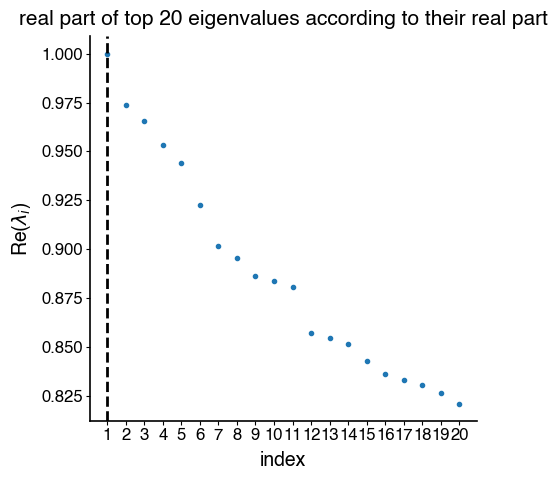

In [38]:
g.compute_schur()
g.plot_spectrum(real_only=True)

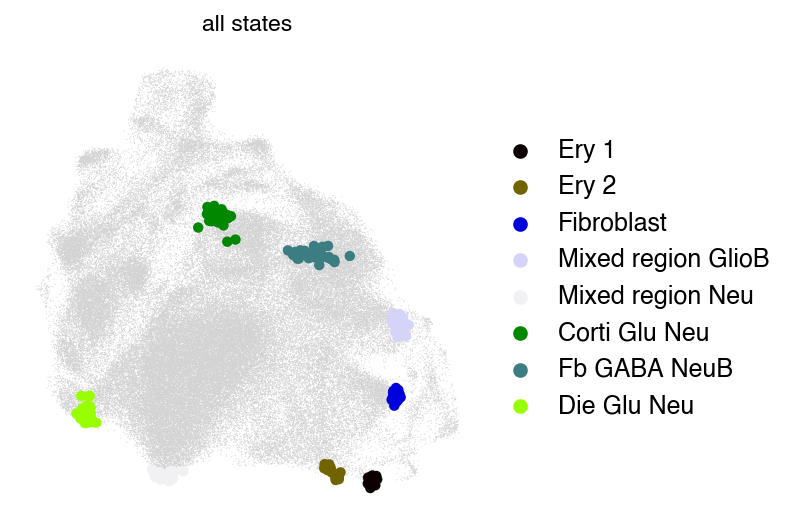

In [39]:
g.compute_macrostates(n_states=8, cluster_key="labels")
g.plot_macrostates(which="all", legend_loc='right', dpi=150, s=100)

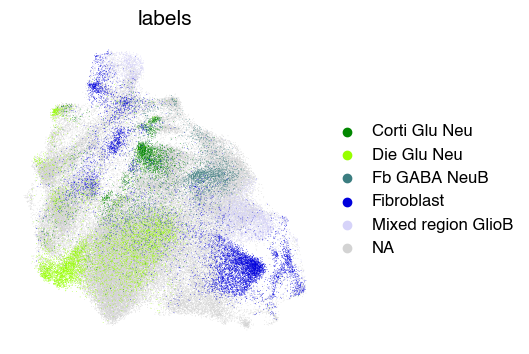

In [40]:
sc.pl.umap(
    adata_late, 
    groups=[
        "Erythrocyte", 
        "Fibroblast",
        "Mixed region GlioB", 
        "Mixed region neu",
        "Corti Glu Neu",
        "Die Glu Neu",
        "Fb GABA NeuB"
    ],
    color="labels",
    frameon=False,
    show=False,
)

if save_figure:
    plt.savefig(FIG_DIR + "umap_macros_brain.png", bbox_inches="tight", transparent=True, dpi=300)
plt.show()

In [41]:
# Merge Erythrocytes
states = {"Ery": list(g.macrostates[g.macrostates.isin(["Ery_1", "Ery_2"])].index)}

groups = [
        "Erythrocyte", 
        "Fibroblast",
        "Mixed region GlioB", 
        "Mixed region neu",
        "Corti Glu Neu",
        "Die Glu Neu",
        "Fb GABA NeuB"
    ]
for state in groups:
    states[state] = list(g.macrostates[g.macrostates.isin([state])].index)

# Manually set these to be terminal
g.set_terminal_states(states=states)

g.compute_absorption_probabilities()

  0%|          | 0/6 [00:00<?, ?/s]

In [42]:
labels_colors_dict = {cat: adata_labels.uns["labels_colors"][i] for i, cat in enumerate(adata_labels.obs["labels"].cat.categories)}

In [43]:
term_states_colors = {cat: labels_colors_dict[cat.split("_")[0]] for cat in g.terminal_states.cat.categories}

g._term_states_colors  = [term_states_colors[state] for state in g.terminal_states.cat.categories]
adata_late.uns["terminal_states_colors"] = [term_states_colors[state] for state in adata_late.obs["term_states_fwd"].cat.categories]

In [44]:
for terminal in g.terminal_states.cat.categories:
    print(terminal)
    adata_late.obs[f'to_{terminal}'] = g.absorption_probabilities[terminal].X.flatten().copy()

Corti Glu Neu
Die Glu Neu
Ery
Fb GABA NeuB
Fibroblast
Mixed region GlioB


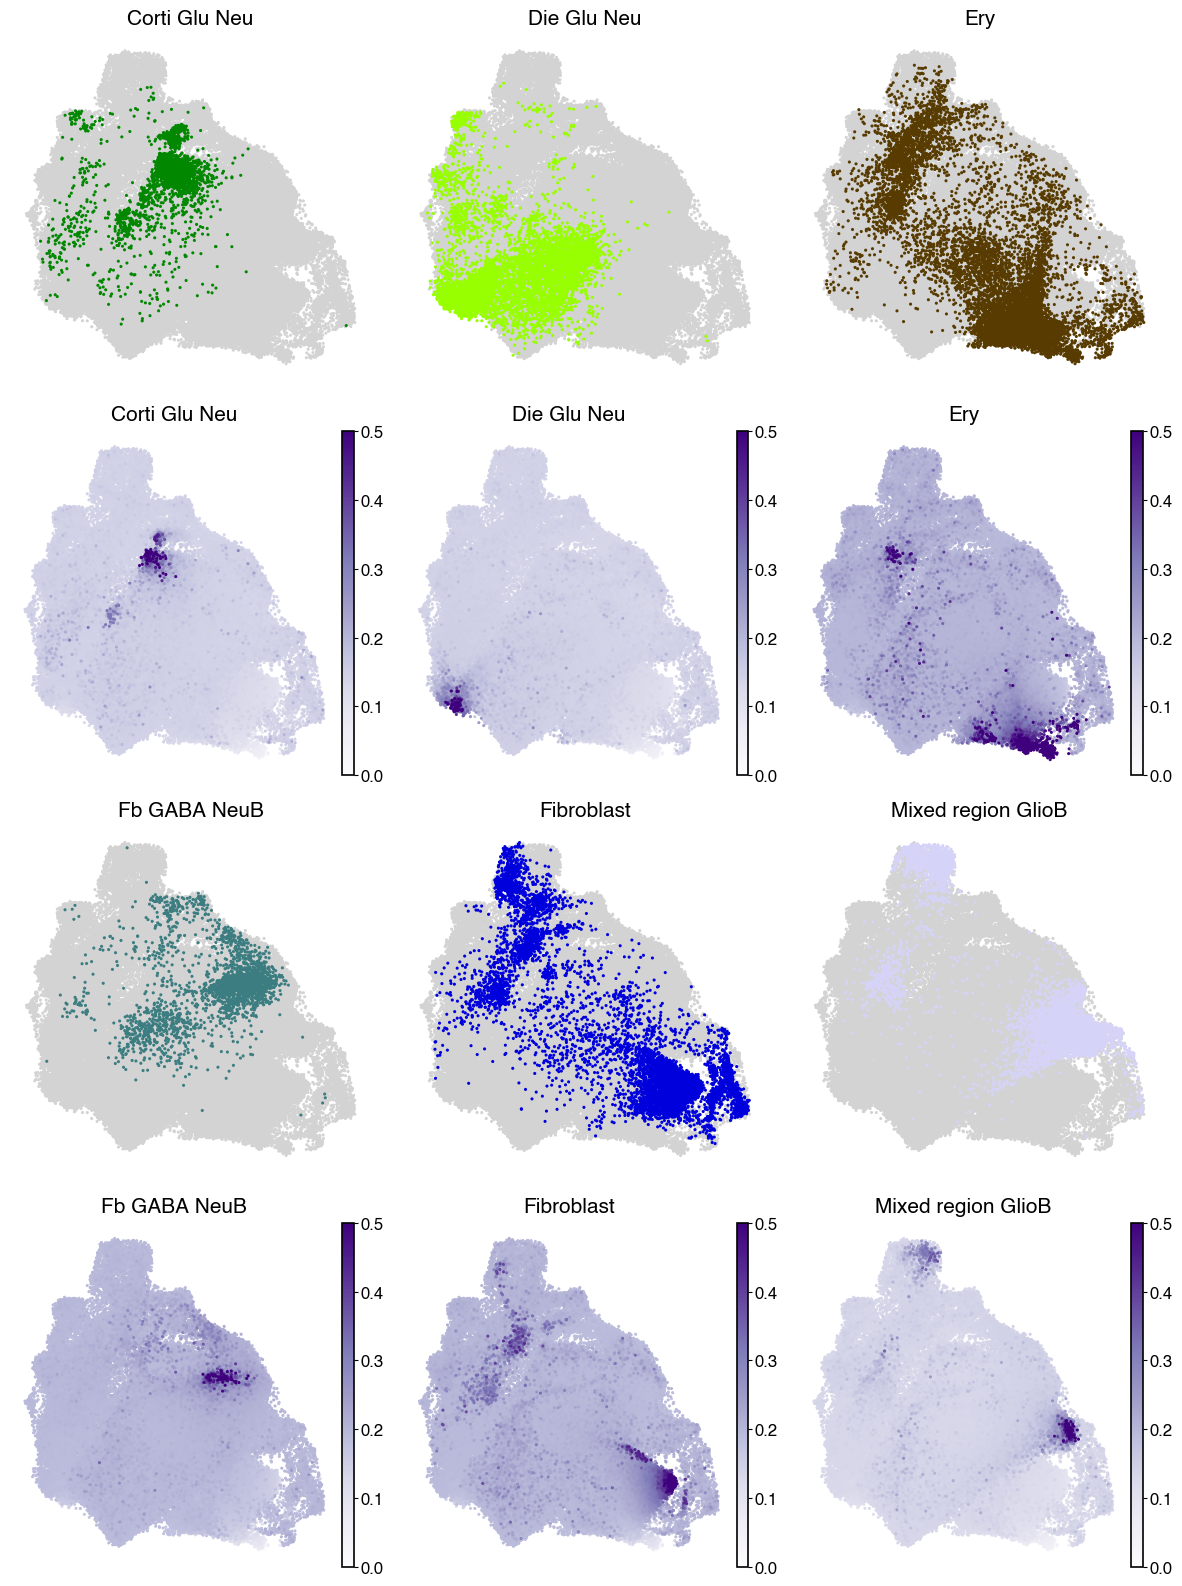

In [45]:
DPI = 300
fig, axs = plt.subplots(4, 3, figsize=(12,16))
for i, cat in enumerate(g.terminal_states.cat.categories):
    if i < 3:
        j = 0
        k = i
    else:
        j = 2
        k = i-3
    sc.pl.umap(adata_late, color=["labels"], groups=[cat], s=20, ax=axs[j, k],show=False, frameon=False, title=cat)
    sc.pl.umap(
        adata_late,
        color=[f"to_{cat}"],
        s=20, 
        ax=axs[j+1, k],
        show=False, 
        frameon=False, 
        title=cat, 
        vmax=0.5, 
        cmap="Purples",
#         colorbar_loc=None
    )
    axs[j, k].legend().remove()

# axs[2, 3].remove()
# axs[3, 3].remove()
plt.tight_layout()
if save_figure:
    plt.savefig(FIG_DIR + f"umap_macros_brain_cbar.png", bbox_inches="tight", transparent=True, dpi=300)
    
plt.show()

### Compute fate probabilities towards aggregated terminal states

In [46]:
# Extract the cell indices for each group of cells
ery_ixs = list(g.macrostates[g.macrostates.isin(['Ery_1', 'Ery_2'])].index)
glio_ixs = list(g.macrostates[g.macrostates.isin(['Mixed region glioblast'])].index)
neuron_ixs = list(g.macrostates[g.macrostates.isin(['Mixed region Neu','Corti Glu Neu', 'Die Glu Neu'])].index)
neuroblast_ixs = list(g.macrostates[g.macrostates.isin(["Fb GABA NeuB"])].index)
fibroblast_ixs = list(g.macrostates[g.macrostates.isin(["Fibroblast"])].index)
    
# Manually set these to be terminal
g.set_terminal_states(states={
    "Erythrocytes": ery_ixs,
    "Glioblasts": glio_ixs,
    "Neuron": neuron_ixs,
    "Neuroblast": neuroblast_ixs,
    "Fibroblast": fibroblast_ixs
})

g.compute_absorption_probabilities()

  0%|          | 0/4 [00:00<?, ?/s]

In [47]:
corrs = g.compute_lineage_drivers(cluster_key='time')

# Merge this on the `.var` annotation to have information about which of these are also TFs!
new_var = adata_late.var.merge(right=corrs, how='left', left_index=True, right_index=True)

# make sure the index is exactly the same as in adata.var
assert((adata_late.var.index == new_var.index).all()), "Indices do not fully overlap"

# put the new var anntations in place
adata_late.var = new_var

Top 20 `Fibroblast` driver genes 

In [48]:
fibro_df = return_drivers(adata_late, states=["Fibroblast"])
fibro_df

highly_variable  highly_variable_rank  Fibroblast_pval  \
Col1a2               True                  11.0              0.0   
Col1a1               True                  26.0              0.0   
Sparc                True                 413.0              0.0   
Col3a1               True                 443.0              0.0   
H19                  True                 195.0              0.0   
Col12a1              True                 588.0              0.0   
Igf2                False                1634.0              0.0   
Col5a2              False                   NaN              0.0   
Fn1                 False                1545.0              0.0   
Cdk8                 True                 228.0              0.0   
Lgals1              False                   NaN              0.0   
Fstl1               False                   NaN              0.0   
Thbs2               False                   NaN              0.0   
Serpinh1            False                   NaN              0.0   
Sfrp2                True                 683.0              0.0   
Prrx1               False                   NaN              0.0   
Col11a1             False                   NaN              0.0   
Dcn                  True                 385.5              0.0   
Ahnak               False                   NaN              0.0   
Cdkn1c              False                1946.0              0.0   

          Fibroblast_corr  
Col1a2           0.510448  
Col1a1           0.502546  
Sparc            0.376609  
Col3a1           0.369190  
H19              0.335755  
Col12a1          0.308597  
Igf2             0.289683  
Col5a2           0.272106  
Fn1              0.251986  
Cdk8             0.250158  
Lgals1           0.242591  
Fstl1            0.241719  
Thbs2            0.241484  
Serpinh1         0.224158  
Sfrp2            0.209020  
Prrx1            0.201106  
Col11a1          0.197787  
Dcn              0.191611  
Ahnak            0.179839  
Cdkn1c           0.179028

Top 20 `Fibroblast` driver transcription factor genes 

In [49]:
fibro_tf_df = return_drivers(adata_late, states=["Fibroblast"], TF=True)
fibro_tf_df

highly_variable  highly_variable_rank  Fibroblast_pval  \
Prrx1              False                   NaN     0.000000e+00   
Runx2              False                1596.0     0.000000e+00   
Jarid2             False                   NaN     0.000000e+00   
Bnc2                True                 682.5    3.174795e-244   
Prdm6              False                1214.0    3.890091e-220   
Msx2               False                   NaN    2.348542e-215   
Creb3l1            False                   NaN    3.631181e-184   
Alx4               False                   NaN    2.553171e-172   
Twist1             False                   NaN    3.905035e-165   
Peg3               False                1465.0    3.500937e-142   
Msx1                True                  79.5    2.009853e-141   
Foxc1              False                   NaN    1.061847e-121   
Maf                False                   NaN    2.739396e-115   
Tbx15              False                   NaN    2.897971e-115   
Nfic               False                   NaN    2.508999e-108   
Six2               False                   NaN     1.770529e-88   
Mkx                False                   NaN     4.506230e-85   
Prrx2              False                   NaN     9.515891e-84   
Klf4               False                   NaN     3.988333e-81   
Osr1               False                   NaN     3.243204e-73   

         Fibroblast_corr  
Prrx1           0.201106  
Runx2           0.121334  
Jarid2          0.117762  
Bnc2            0.099553  
Prdm6           0.094502  
Msx2            0.093466  
Creb3l1         0.086399  
Alx4            0.083555  
Twist1          0.081781  
Peg3            0.075832  
Msx1            0.075628  
Foxc1           0.070094  
Maf             0.068197  
Tbx15           0.068190  
Nfic            0.066075  
Six2            0.059611  
Mkx             0.058429  
Prrx2           0.057963  
Klf4            0.057029  
Osr1            0.054114

In [50]:
fibro_full = pd.concat((fibro_tf_df, fibro_df), keys=['TF', 'all genes']).reset_index().rename(columns={
    "level_0": "gene_set",
    "level_1": "gene_name"
})[['gene_name', 'gene_set', 'Fibroblast_pval', 'Fibroblast_corr', 'highly_variable', 'highly_variable_rank']]
fibro_full.to_csv(DATA_DIR + "Fibroblast_drivers.csv")

Top 20 `Neuron` driver genes 

In [51]:
neuro_df = return_drivers(adata_late, states=["Neuron"])
neuro_df

highly_variable  highly_variable_rank  Neuron_pval  Neuron_corr
Tuba1a            False                   NaN          0.0     0.318739
Tenm2              True                  30.0          0.0     0.260854
Lrba              False                   NaN          0.0     0.237365
Stmn2              True                 514.0          0.0     0.231501
Stmn1             False                   NaN          0.0     0.230035
Tmsb10            False                1271.5          0.0     0.222537
Map1b              True                 404.0          0.0     0.216014
Nrg3               True                  51.5          0.0     0.215842
Gap43              True                 106.0          0.0     0.198769
Malat1             True                 180.5          0.0     0.195207
Nrxn1              True                 100.0          0.0     0.192207
Rbfox1             True                  33.5          0.0     0.191790
Tubb3             False                1626.5          0.0     0.191528
Dpysl3            False                1395.0          0.0     0.187199
Pcdh9              True                  19.0          0.0     0.185203
Nnat               True                 240.0          0.0     0.183496
Tubb2b            False                   NaN          0.0     0.179133
Rtn1              False                1046.0          0.0     0.178280
Mapt               True                 337.0          0.0     0.178254
Tubb2a            False                1370.0          0.0     0.176505

Top 20 `Neuron` driver transcription factor genes

In [52]:
neuro_tf_df = return_drivers(adata_late, states=["Neuron"], TF=True)
neuro_tf_df

highly_variable  highly_variable_rank    Neuron_pval  Neuron_corr
Tcf7l2              True                   9.5   0.000000e+00     0.144555
Sox11               True                 573.0   0.000000e+00     0.136796
Myt1l               True                 598.5   0.000000e+00     0.126746
Csrnp3             False                1855.5  7.723151e-277     0.106000
Sox5                True                 272.5  4.748627e-269     0.104498
Ybx1               False                   NaN  9.892500e-233     0.097177
Zfhx3               True                 235.0  6.108250e-206     0.091392
Id4                 True                 380.0  2.170621e-181     0.085741
Prox1              False                1793.0  2.450910e-170     0.083069
Camta1             False                   NaN  1.321901e-151     0.078330
Nr2f1               True                 176.5  3.577729e-139     0.075017
Thra               False                   NaN  2.346973e-133     0.073415
Pou2f2              True                 863.5  4.540559e-120     0.069616
Tub                False                   NaN  2.998768e-117     0.068783
Klf7               False                1430.5  8.661811e-110     0.066527
Tbr1                True                  52.0  1.620083e-107     0.065824
Bcl11a              True                 828.0  1.606560e-101     0.063933
Neurod2             True                 144.0  2.327381e-100     0.063560
Sox4               False                   NaN   1.499826e-99     0.063299
Lhx9                True                 357.5   3.137340e-93     0.061221

In [53]:
neuro_full = pd.concat((neuro_tf_df, neuro_df), keys=['TF', 'all genes']).reset_index().rename(columns={
    "level_0": "gene_set",
    "level_1": "gene_name"
})[['gene_name', 'gene_set', 'Neuron_pval', 'Neuron_corr', 'highly_variable', 'highly_variable_rank']]
neuro_full.to_csv(DATA_DIR + "Neuronal_drivers.csv")

In [54]:
neuron_genes = [
    "Sox11",
    "Myt1l",
    "Gata3",
    "Zfhx3",
    "Neurod2",
    "Rbfox1",
    "Tuba1a",
    "Tenm2"
]


fibro_genes = [
    "Prrx1",
    "Runx2",
    "Maf",
    "Col1a2",
    "Col1a1",
    "Dcn", 
]

adata_late.var["drivers"] = "Other gene"
adata_late.var.loc[adata_late.var["TF"] ,"drivers"] = "TF"

adata_late.var.loc[adata_late.var_names.isin(fibro_genes), "drivers"] = "Fibroblasts"
adata_late.var.loc[adata_late.var_names.isin(neuron_genes), "drivers"] = "Neurons"

adata_late.var["drivers"] = adata_late.var["drivers"].astype("category")
adata_late.var["drivers"] = adata_late.var["drivers"].cat.reorder_categories(["Other gene",  "TF", "Fibroblasts", "Neurons"])

# Define a list of colors
colors = ["#C0C0C0", "#000000", "#0023DD", "#95B577"]

adata_late.uns["drivers_colors"] = colors

In [55]:
# Normalize the colormap range
cmap_range = mcolors.Normalize(vmin=0, vmax=len(colors))

# Create the colormap object
cmap = mcolors.ListedColormap(colors)

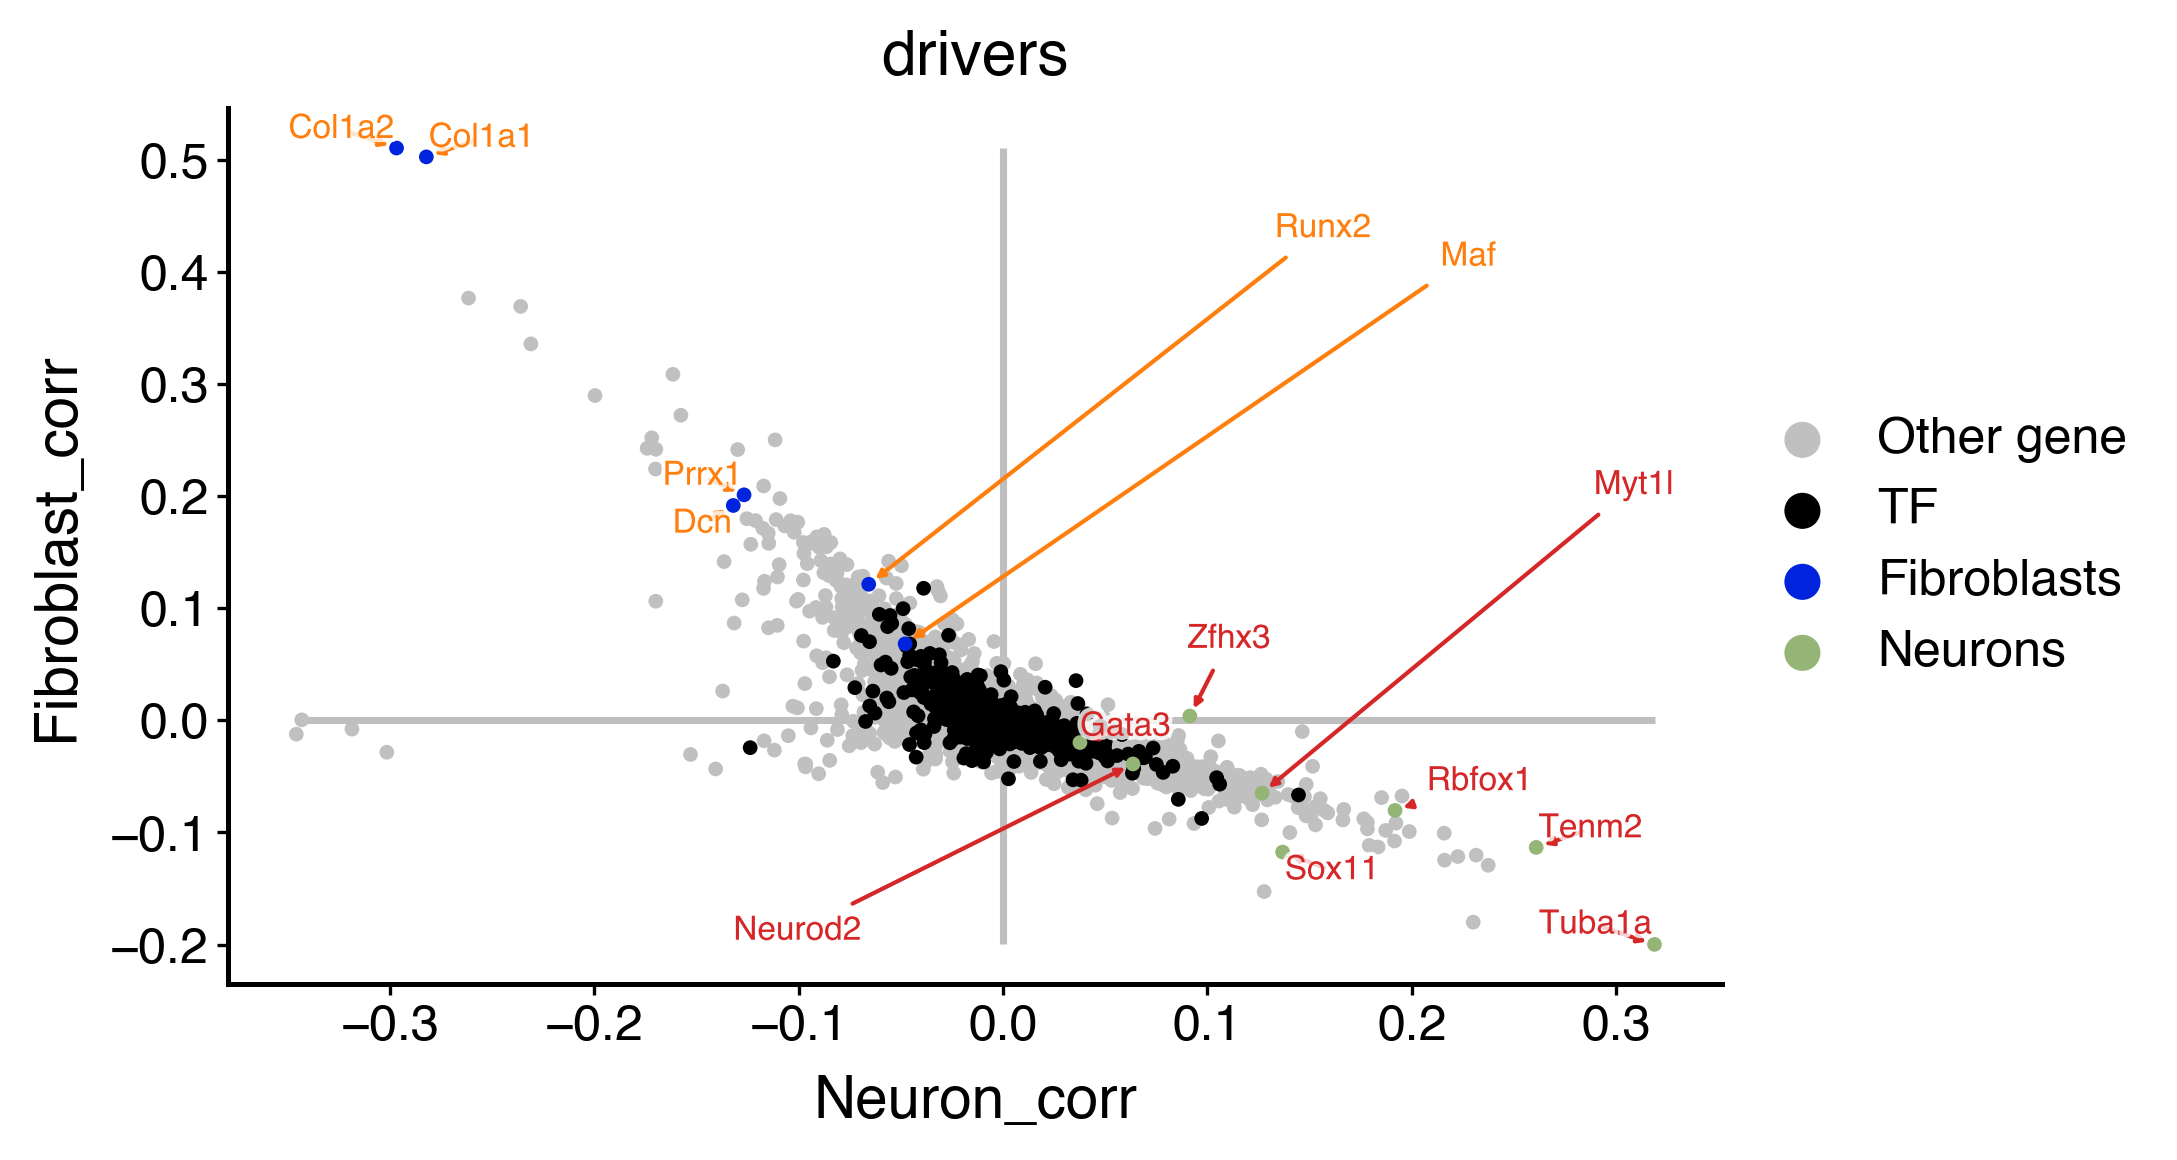

In [56]:
g.plot_lineage_drivers_correlation(
    lineage_x="Neuron", 
    adjust_text=True, 
    lineage_y="Fibroblast",
    gene_sets={"Neuron":neuron_genes,
               "Fibroblast": fibro_genes
              },
    legend_loc="none",
    color="drivers",
    cmap=colors,
    figsize=(6, 4),
    dpi=300,
    fontsize=8,
    title="driver genes",
    size=50,
)
if save_figure:
    plt.savefig(FIG_DIR + "drivers_brain_annotated.png", bbox_inches="tight", transparent=True, dpi=300)
plt.show()

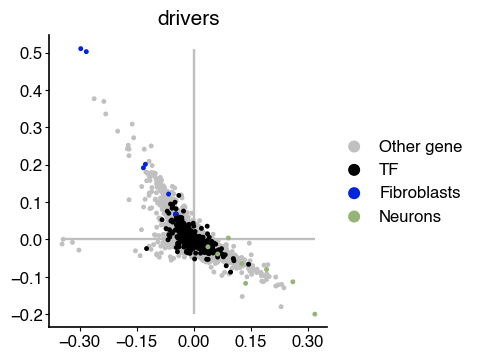

In [57]:
# call the actual plotting method via the estimator object
ax = g.plot_lineage_drivers_correlation(
    lineage_x="Neuron", 
    adjust_text=True, 
    lineage_y="Fibroblast",
    color="drivers", 
    cmap=cmap,
    legend_loc="none",
    title="driver genes",
    size=50,
    show=False, 
)

# adjust and save
ax.set_xticks([-0.3, -0.15, 0.0, 0.15, 0.3])
ax.set_xlabel("")
ax.set_ylabel("")
if save_figure:
    plt.savefig(FIG_DIR + "drivers_brain_correlations.png", bbox_inches="tight", transparent=True, dpi=300)
    
plt.show()

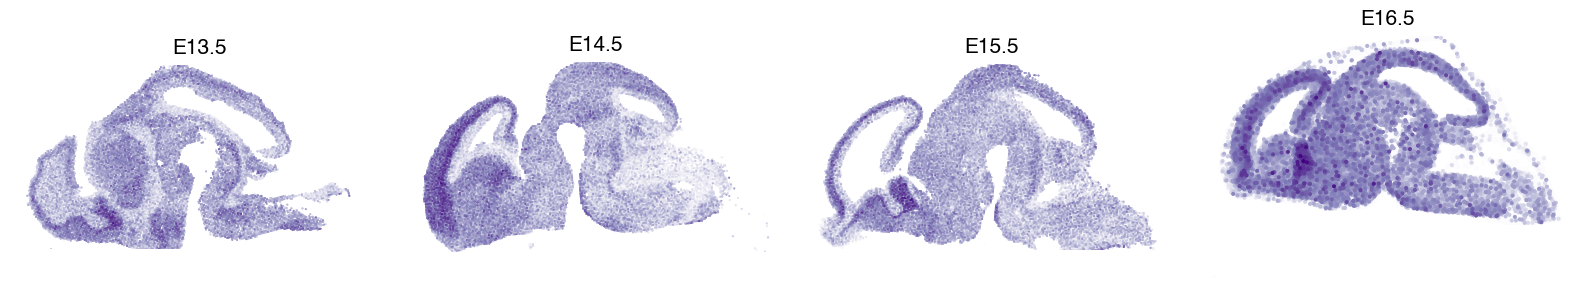

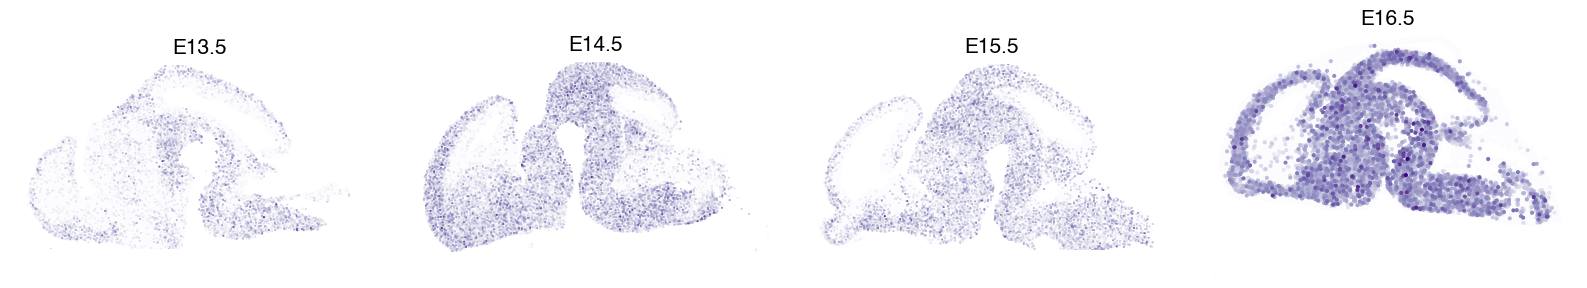

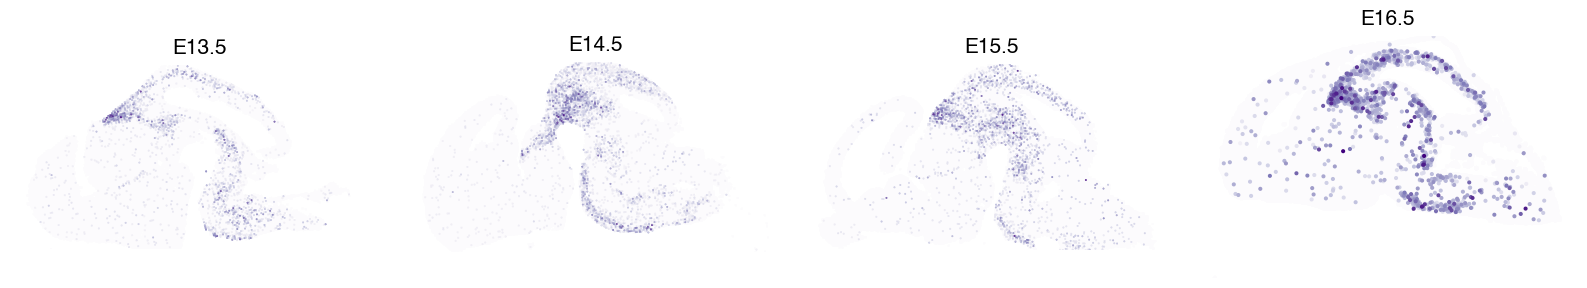

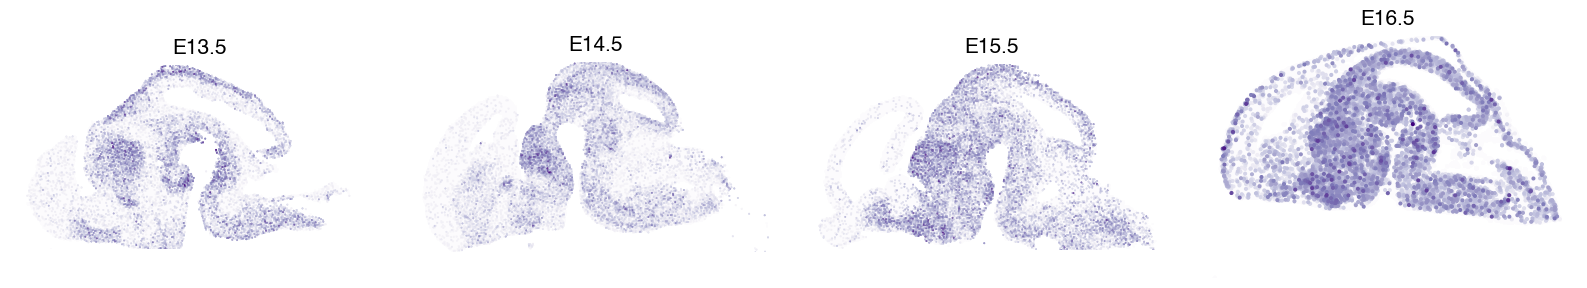

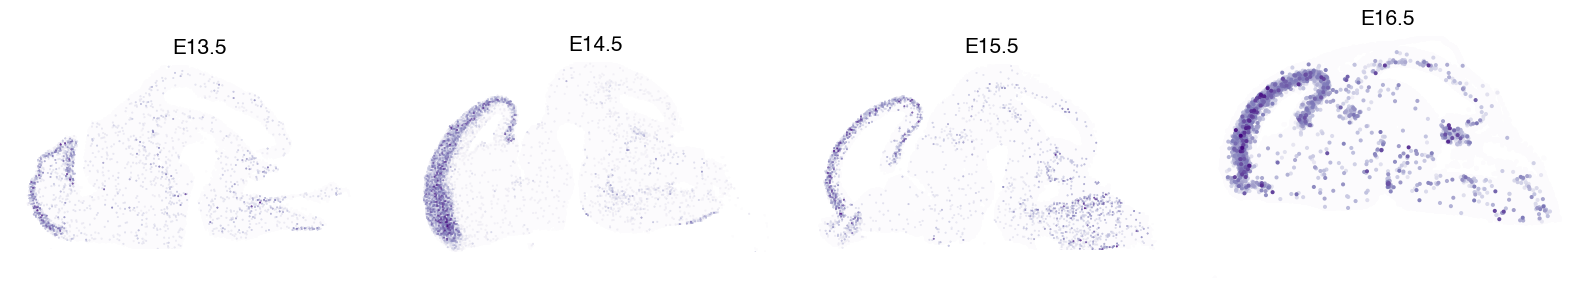

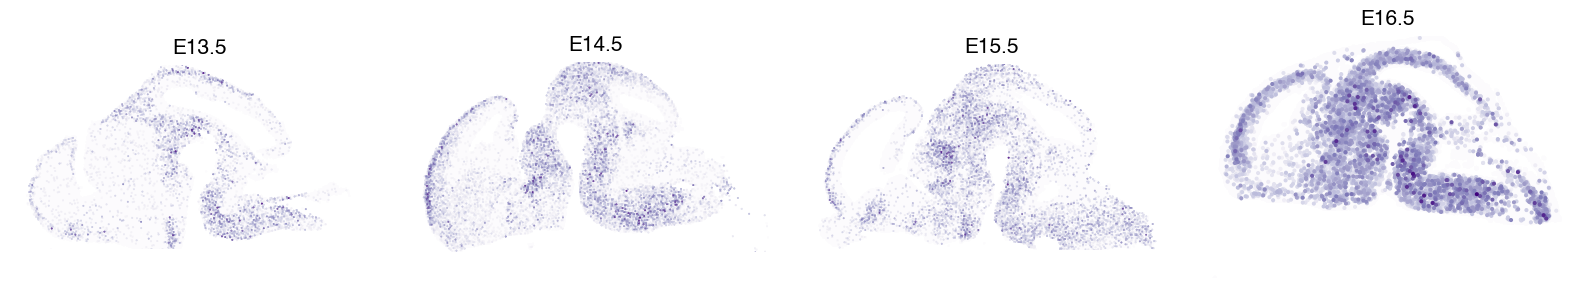

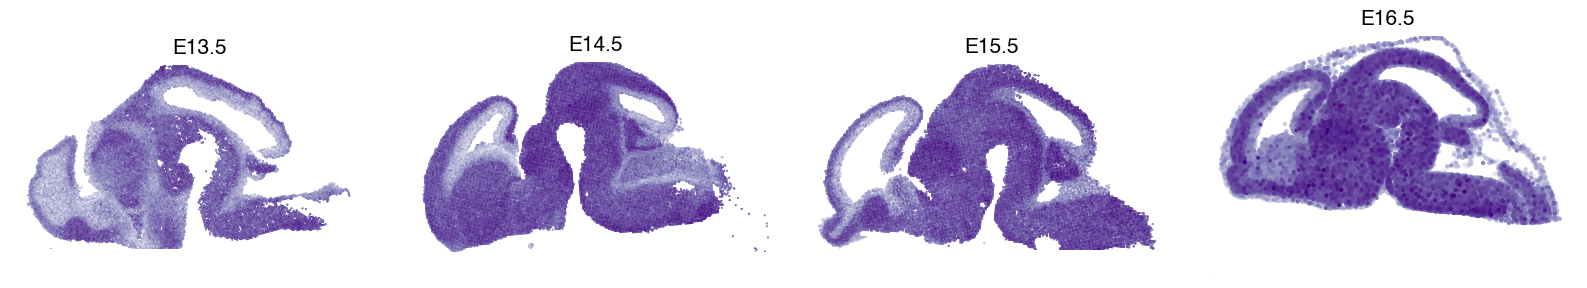

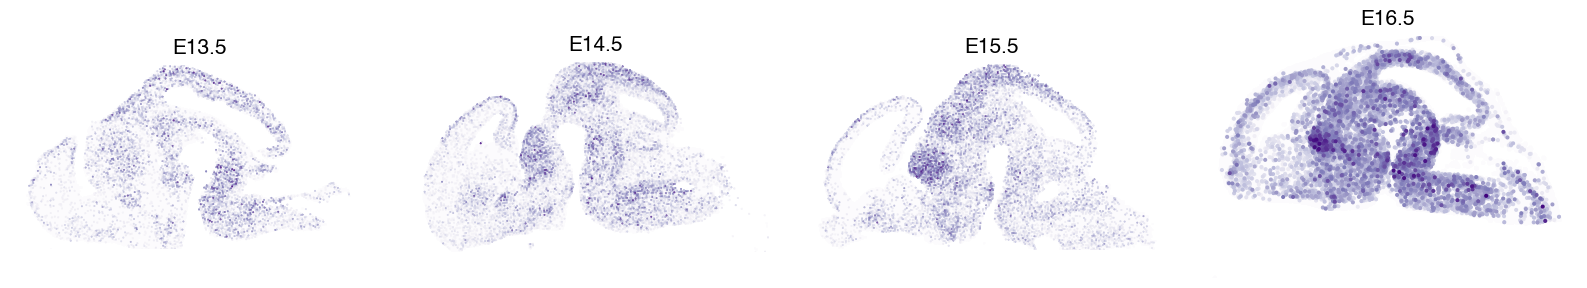

In [58]:
for gene in neuron_genes:
    DPI = 300
    fig, axs = plt.subplots(1, 4, figsize=(16,4))
    for i, time in enumerate(adata_late.obs["time"].cat.categories):
        adata_tp = adata_late[adata_late.obs["time"].isin([time])].copy()
        
        sq.pl.spatial_scatter(
            adata_tp[adata_tp[:, gene].X.A.flatten().argsort()],
            shape=None,
            color=gene,  # , "Myl7", "Alas2", "Gata4"],
            frameon=False,
            cmap="Purples",
            size=adata_late.uns["spatial_dicts"]["time_size"][time],
            img=False,
            dpi=300,
            colorbar=None,
            ax=axs[i]
        )
        axs[i].set_title(f"E{time}")
        axs[i].set_ylim(adata_late.uns["spatial_dicts"]["ylim"][time])
    
    plt.tight_layout()
    if save_figure:
        plt.savefig(FIG_DIR + f"neurons_{gene}_brain.png", bbox_inches="tight", transparent=True, dpi=300)
   
    
plt.show()

[[1] Ao Chen, Sha Liao, Mengnan Cheng, Kailong Ma, Liang Wu, Yiwei Lai, Xiaojie Qiu et al. "Spatiotemporal transcriptomic atlas of mouse organogenesis using DNA nanoball-patterned arrays." Cell (2022)](https://doi.org/10.1016/j.cell.2022.04.003)